<a href="https://colab.research.google.com/github/shirleynguyena/portfolio/blob/main/Landslide_Fatality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Landslide Fatality Prediction
This is a Random Forest model to predict the number of fatalities from landslides using data collected by the NASA Goddard Space Flight Center since 2007. The data is from the [Global Landslide Catalog](https://catalog.data.gov/dataset/global-landslide-catalog).

Created by Shirley Nguyen, December 2021.

## 1. Reading the raw data

In [105]:
# pip install category_encoders

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from google.colab import drive
import os

In [107]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/AOS111/glc_data.csv')

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,the_geom,OBJECTID,id,date_,time_,country,nearest_pl,hazard_typ,landslide_,trigger,storm_name,fatalities,injuries,source_nam,source_lin,location_a,landslide1,photos_lin,cat_src,cat_id,countrynam,near,distance,adminname1,adminname2,population,countrycod,continentc,key_,version,user_id,tstamp,changeset_,latitude,longitude
0,POINT (-73.40200000000006 41.55850000000008),1,3177,03/07/2011 08:00:00 AM +0000,12/30/1899 08:00:00 AM +0000,United States,Grove Street from Anderson Avenue to Hine Hill...,landslide,Mudslide,Downpour,NaN,0,0,NaN,http://www.newstimes.com/local/article/New-Mil...,Known_within_1_km,Medium,NaN,glc,3177,United States,New Milford,2.12825,Connecticut,Litchfield County,6523,NaN,NaN,US,1,1,Tue Apr 01 2014 00:00:00 GMT+0000 (UTC),1,41.5585,-73.4020
1,POINT (113.91710000000012 0.1115000000000351),2,490,04/01/2008 07:00:00 AM +0000,NaN,Indonesia,"Borneo, Muara",landslide,Landslide,Rain,NaN,0,0,NaN,http://www.brunei-online.com/bb/tue/apr1h10.htm,Unknown,Medium,NaN,glc,490,Indonesia,Longnawang,215.44888,North Kalimantan,NaN,0,NaN,AS,ID,1,1,Tue Apr 01 2014 00:00:00 GMT+0000 (UTC),1,0.1115,113.9171
2,POINT (-127.69800000000009 52.35450000000008),3,6760,01/30/2015 08:00:00 AM +0000,12/30/1899 08:00:00 AM +0000,NaN,"Ocean Falls, B.C.",landslide,Mudslide,Rain,NaN,0,0,Global News,http://globalnews.ca/news/1818913/mudslide-spl...,Known_within_1km,Medium,http://vipmedia.globalnews.ca/2015/02/10954548...,glc,6760,Canada,Kitimat,199.44893,British Columbia,obe,8987,NaN,NaN,CA,2,7,Tue Feb 17 2015 15:42:41 GMT+0000 (UTC),3910846556,52.3545,-127.6980
3,POINT (-127.50620000000009 50.70530000000013),4,2494,09/24/2010 07:00:00 AM +0000,NaN,Canada,"road to Holberg, 3 km from hwy 19, Vancouver I...",landslide,Complex,Downpour,NaN,0,0,NaN,http://www.theprovince.com/news/State+emergenc...,Known_within_1_km,Medium,NaN,glc,2494,Canada,Campbell River,178.23706,British Columbia,NaN,33430,NaN,NaN,CA,1,1,Tue Apr 01 2014 00:00:00 GMT+0000 (UTC),1,50.7053,-127.5062
4,POINT (-132.41490000000013 53.331900000000125),5,6415,08/31/2014 07:00:00 AM +0000,12/30/1899 08:00:00 AM +0000,NaN,Rennell Sound Road,landslide,Mudslide,Downpour,NaN,0,0,CFTK,http://www.cftktv.com/News/Story.aspx?ID=2164634,Known_within_15km,Small,http://www.cftktv.com/Pics/PhotoAlbums/Police%...,glc,6415,Canada,Prince Rupert,176.02202,British Columbia,obe,14708,NaN,NaN,CA,1,7,Thu Dec 04 2014 15:14:07 GMT+0000 (UTC),1280292118,53.3319,-132.4149


## 2. Data Pre-Processing


### 2.1 Cleaning up features

In [108]:
# Extract non-duplicate data
data = data.loc[:, ('landslide_', 'trigger', 'fatalities', 'injuries',
                    'landslide1', 'distance', 'population', 'key_', 'latitude',
                    'longitude')]

# Rename columns
data.rename(columns={'landslide_': 'event', 'landslide1': 'size',
                     'key_': 'countries'}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6788 entries, 0 to 6787
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   event       6788 non-null   object 
 1   trigger     6788 non-null   object 
 2   fatalities  6788 non-null   int64  
 3   injuries    6788 non-null   int64  
 4   size        6786 non-null   object 
 5   distance    6788 non-null   float64
 6   population  6788 non-null   int64  
 7   countries   6786 non-null   object 
 8   latitude    6788 non-null   float64
 9   longitude   6788 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 530.4+ KB


### 2.2 Investigating target data

count    6788.000000
mean        3.739982
std        70.827594
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      5000.000000
Name: fatalities, dtype: float64


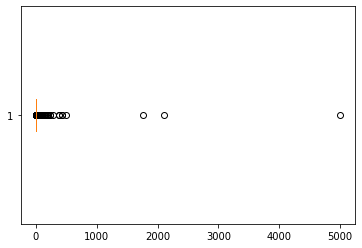

In [109]:
# Statistical summary
print(data['fatalities'].describe())
fig1 = plt.boxplot(data['fatalities'], vert=False)

count    6785.000000
mean        2.435077
std        15.245638
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       491.000000
Name: fatalities, dtype: float64


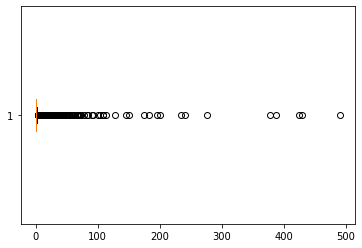

In [110]:
# Remove 3 outliers
data = data[data['fatalities'] < 1000]
print(data['fatalities'].describe())
fig1 = plt.boxplot(data['fatalities'], vert=False)

### 2.3 Encoding categorical data

In [111]:
# Check current levels
for col in data.loc[:, ('event', 'trigger', 'size', 'countries')]:
    print('Levels for {}: {}\n'.format(col, data[col].unique()))

Levels for event: ['Mudslide' 'Landslide' 'Complex' 'Other' 'Rock_Fall' 'Debris_Flow'
 'Rockfall' 'Snow_Avalanche' 'Unknown' 'Translational_Slide' 'mudslide'
 'Creep' 'Lahar' 'Riverbank_Collapse' 'landslide']

Levels for trigger: ['Downpour' 'Rain' 'Snowfall_snowmelt' 'unknown' 'Unknown' 'Earthquake'
 'No_Apparent_trigger' 'Freeze_thaw' 'Continuous_rain' 'Construction'
 'Monsoon' 'Continuous_Rain' 'Tropical_Cyclone' 'Mining_digging'
 'Dam_Embankment_Collapse' 'Other' 'mining_digging' 'Snowfall' 'monsoon'
 'Flooding' 'No_Apparent_Trigger' 'other']

Levels for size: ['Medium' 'Small' 'Large' 'Very_large' 'unknown' 'large' 'medium' 'small'
 nan]

Levels for countries: ['US' 'ID' 'CA' 'PE' 'MM' 'NZ' 'FJ' 'IN' 'VU' 'MY' 'TJ' 'IS' 'CN' 'AU'
 'PK' 'AR' 'NP' 'BR' 'UG' 'KG' 'NI' 'CO' 'BO' 'KE' 'EC' 'GB' 'BD' 'PG'
 'AF' 'KP' 'ET' 'CL' 'NG' 'TW' 'HN' 'JP' 'LA' 'MG' 'VN' 'TT' 'GH' 'BN'
 'MX' 'RW' 'LK' 'MW' 'TH' 'BT' 'PT' 'PH' 'SB' 'NO' 'ZA' 'RU' 'IR' 'IE'
 'GT' 'AZ' 'CR' 'KR' 'BF' 'VE' 'GE' 'JO' '

In [112]:
# Clean up levels
data['event'].replace({'Rock_Fall': 'Rockfall', 'mudslide': 'Mudslide', 
                       'landslide': 'Landslide', 'Lahar': 'Debris_Flow', 
                       'Other': None, 'Unknown': None}, inplace=True)
data['trigger'].replace({'unknown': None, 'Continuous_rain': 'Continuous_Rain',
                         'Other': None, 'other': None,
                         'No_Apparent_trigger': 'No_Apparent_Trigger',
                         'monsoon': 'Monsoon', 'mining_digging': 'Mining', 
                         'Mining_digging': 'Mining', 
                         'Snowfall_snowmelt': 'Snowfall', 'Unknown': None}, 
                         inplace=True)
data['size'].replace({'large': 'Large', 'medium': 'Medium', 'small': 'Small', 
                      'unknown': None, '': None}, inplace=True)

# Check updated levels
for col in data.loc[:, ('event', 'trigger', 'size')]:
    print('Levels for {}: {}\n'.format(col, data[col].unique()))

Levels for event: ['Mudslide' 'Landslide' 'Complex' None 'Rockfall' 'Debris_Flow'
 'Snow_Avalanche' 'Translational_Slide' 'Creep' 'Riverbank_Collapse']

Levels for trigger: ['Downpour' 'Rain' 'Snowfall' None 'Earthquake' 'No_Apparent_Trigger'
 'Freeze_thaw' 'Continuous_Rain' 'Construction' 'Monsoon'
 'Tropical_Cyclone' 'Mining' 'Dam_Embankment_Collapse' 'Flooding']

Levels for size: ['Medium' 'Small' 'Large' 'Very_large' None nan]



In [113]:
# Encoding 

# Size is ordinal
data['size'].replace({'Small': 1, 'Medium': 2, 'Large': 3, 'Very_large': 4, 
                      'Extra Large': 5}, inplace=True)
data['size'].replace({None: data['size'].mean(skipna=True)}, inplace=True)

# Target encoding for the nominal features with more levels
encoder = TargetEncoder()
data.loc[:, ('event', 'trigger', 'countries')] = encoder.fit_transform(
    data.loc[:, ('event', 'trigger', 'countries')], data['fatalities'])

# All data should be floats or ints now
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6785 entries, 0 to 6787
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   event       6785 non-null   float64
 1   trigger     6785 non-null   float64
 2   fatalities  6785 non-null   int64  
 3   injuries    6785 non-null   int64  
 4   size        6785 non-null   float64
 5   distance    6785 non-null   float64
 6   population  6785 non-null   int64  
 7   countries   6785 non-null   float64
 8   latitude    6785 non-null   float64
 9   longitude   6785 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 903.1 KB


## 3. Data splitting

In [114]:
X = data.drop('fatalities', axis=1)
y = data['fatalities']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size = 0.8, test_size=0.2, random_state=12)

## 4. Random Forest Regressor

Train MAE:  1.2144805242657122
Train RMSE:  6.031556960531663
Train R^2:  0.8482800517850594 

Test MAE:  2.6303486507351654
Test RMSE:  11.681987501586848
Test R^2:  0.3272306776534931 



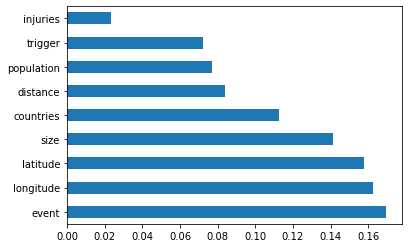

In [115]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = (rfr.predict(X_test))

y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)

# Metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
train_r2 = rfr.score(X_train, y_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)

print('Train MAE: ', train_mae)
print('Train RMSE: ', train_rmse)
print('Train R^2: ', train_r2, '\n')
print('Test MAE: ', test_mae)
print('Test RMSE: ', test_rmse)
print('Test R^2: ', test_r2, '\n')

# Feature importance
feat_importances = pd.Series(rfr.feature_importances_, index=X.columns)
feat_importances.nlargest(9).plot(kind='barh')

## 5. Tuning

In [116]:
# Drop injuries feature
X = X.drop('injuries', axis=1)

Train MAE:  2.717045979097677
Train RMSE:  12.19612620074886
Train R^2:  0.3796630678151669 

Test MAE:  2.5079346498438597
Test RMSE:  11.17122867958487
Test R^2:  0.3847741294435837 

Best parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 



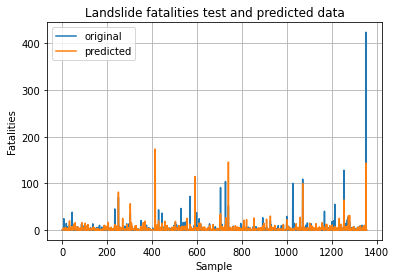

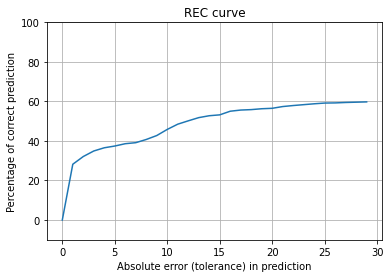

In [117]:
# Find the best model parameters
parameters = {
    'n_estimators': [100, 200],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [4, 5, 6],
    'max_depth': [5, 6, 7],
    'max_features': ['auto', 'sqrt', 'log2']}
search = GridSearchCV(rfr, parameters, scoring='r2', n_jobs=-1)
search.fit(X_train,y_train)

best_rfr = search.best_estimator_
y_pred_train = best_rfr.predict(X_train)
y_pred_test = best_rfr.predict(X_test)

# Metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
train_r2 = best_rfr.score(X_train, y_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)

print('Train MAE: ', train_mae)
print('Train RMSE: ', train_rmse)
print('Train R^2: ', train_r2, '\n')
print('Test MAE: ', test_mae)
print('Test RMSE: ', test_rmse)
print('Test R^2: ', test_r2, '\n')
print('Best parameters: ', best_rfr.get_params(), '\n')

# Plot the prediction
plt.title('Landslide fatalities test and predicted data')
plt.xlabel('Sample')
plt.ylabel('Fatalities')
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label='original')
plt.plot(x_ax, y_pred, label='predicted')
plt.grid(True)
plt.legend()
plt.show()

# Plot the REC curve
def rec(m, n, tol):
    if type(m) != 'numpy.ndarray':
        m = np.array(m)
    if type(n) != 'numpy.ndarray':
        n = np.array(n)
    l = m.size
    percent = 0
    for i in range(l):
        if np.abs(10 ** m[i] - 10 ** n[i]) <= tol:
            percent += 1
    return 100 * (percent / l)

rec_rfr=[]
tol_max = 30
for i in range(tol_max):
    rec_rfr.append(rec(y_pred_test, y_test, i))

plt.title('REC curve')
plt.xlabel('Absolute error (tolerance) in prediction')
plt.ylabel('Percentage of correct prediction')
plt.xticks([i * 5 for i in range(tol_max + 1)])
plt.ylim(-10, 100)
plt.yticks([i * 20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max), rec_rfr)
plt.show()